In [1]:
from dotenv import load_dotenv
from langchain_teddynote import logging

load_dotenv()
logging.langsmith("RAG Agent")

LangSmith 추적을 시작합니다.
[프로젝트명]
RAG Agent


In [15]:
import os
import re
import warnings
from typing import List, Dict

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PDFPlumberLoader,PyMuPDFLoader
from langchain_teddynote.document_loaders import HWPLoader
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.tools import Tool
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_community.tools.tavily_search.tool import TavilySearchResults
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CohereRerank

warnings.filterwarnings("ignore")

# === 기본 설정 ===
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
embeddings = OpenAIEmbeddings()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)

# === 필터 추출 함수 ===
def extract_filter_from_query(query: str) -> Dict:
    crop_match = re.search(r"(딸기|토마토|망고)", query)
    pest_match = re.search(r"([가-힣]+병|응애|진딧물)", query)
    fertilizer_match = re.search(r"(비료|퇴비|질소|인산|칼륨)", query)
    cultivation_match = re.search(r"(재배|파종|정식|관리|관수|시비)", query)

    filters = {}
    if crop_match:
        filters["작물"] = crop_match.group(1)

    if pest_match:
        filters["병해충명"] = pest_match.group(1)

    if fertilizer_match:
        filters["질문유형"] = "비료"
    elif cultivation_match:
        filters["질문유형"] = "재배"
    

    return filters

def infer_task_type(text: str) -> str:
    if re.search(r"(병|해충|응애|곰팡이|진딧물)", text):
        return "병해충"
    elif re.search(r"(질소|인산|칼륨|퇴비|비료)", text):
        return "비료"
    elif re.search(r"(정식|파종|관수|시비|수확|재배|유인|온도|토양)", text):
        return "재배"
    else:
        return "일반"

# === 문서 로더 ===
def load_docs_with_metadata(paths: List[str], crop: str) -> List:
    all_docs = []

    for path in paths:
        if path.lower().endswith(".pdf"):
            loader = PyMuPDFLoader(path)
        elif path.lower().endswith(".hwp"):
            loader = HWPLoader(path)
        else:
            raise ValueError(f"지원하지 않는 파일 형식입니다: {path}")

        docs = loader.load()
        for i, doc in enumerate(docs):
            doc.metadata.update({
                "작물": crop,
                "출처": os.path.basename(path),
                "페이지": i
            })

            task_type = infer_task_type(doc.page_content)
            doc.metadata["질문유형"] = task_type

            if task_type == "병해충":
                match = re.search(r"\d+\.\s*([가-힣]+병|응애|진딧물)", doc.page_content)
                if match:
                    doc.metadata["병해충명"] = ",".join(sorted(set(match)))

            if task_type == "비료":
                fert_matches = re.findall(r"(질소|인산|칼륨|퇴비|비료)", doc.page_content)
                if fert_matches:
                    doc.metadata["비료성분"] = ",".join(sorted(set(fert_matches)))

            if task_type == "재배":
                cultivation_matches = re.findall(r"(정식|파종|관수|시비|수확|유인|온도|토양)", doc.page_content)
                if cultivation_matches:
                    doc.metadata["재배항목"] = ",".join(sorted(set(cultivation_matches)))

        all_docs.extend(docs)

    return all_docs


# 3. 웹 검색 툴
def web_search_with_notice(query: str) -> str:
    results = TavilySearchResults().invoke(query)
    return str(results) + "\n\n🔎 웹 검색 결과를 기반으로 제공된 정보입니다."

web_search_tool = Tool(
    name="web_search_tool",
    func=web_search_with_notice,
    description=(
       "딸기, 토마토, 망고에 대한 작물 재배법, 병해충, 농약 및 비료(퇴비) 관련 정보가 문서에 없거나 부족할 경우, 웹에서 검색을 수행합니다. "
    "최신 정보가 필요한 경우에도 사용하세요. "
    "웹 검색 결과를 활용한 응답일 경우, 반드시 '🔎 웹 검색 결과를 기반으로 제공된 정보입니다.' 문구를 출력해야 합니다."
    )
)

# 4. Chroma 벡터 DB 처리
def get_vectorstore(pdf_path, index_path, crop):
    if os.path.exists(index_path):
        return Chroma(persist_directory=index_path, embedding_function=embeddings)
    docs = load_docs_with_metadata(pdf_path, crop)
    split_docs = text_splitter.split_documents(docs)
    vs = Chroma.from_documents(split_docs, embeddings, persist_directory=index_path)
    vs.persist()
    return vs

# 경로
strawberry_path = ["data/딸기 병해충 및 비료.pdf",
                   "data/딸기(촉성재배) 농작업일정.hwp",
                   "data/과즙이풍부한왕딸기킹스베리재배매뉴얼.pdf"]
tomato_path = ["data/토마토 병해충 및 비료.pdf",
               "data/토마토,방울토마토 농작업일정.hwp",
               "data/과채류(토마토).pdf",
               "data/29 토마토_저화질_단면.pdf"]
mango_path = ["data/아열대과수(망고).pdf",
              "data/2023농업기술길잡이_망고_단면.pdf"]

strawberry_index_path = "chroma_index/strawberry"
tomato_index_path = "chroma_index/tomato"
mango_index_path = "chroma_index/mango"

strawberry_vectorstore = get_vectorstore(strawberry_path, strawberry_index_path, "딸기")
tomato_vectorstore = get_vectorstore(tomato_path, tomato_index_path, "토마토")
mango_vectorstore = get_vectorstore(mango_path, mango_index_path, "망고")

# 5. 필터 기반 retriever tool 래핑
def make_filtered_tool(name, vectorstore, crop_name):
    # 1. 기본 Retriever
    base_retriever = vectorstore.as_retriever(search_kwargs={"k": 10})  # 후보 문서 충분히 확보

    # 2. Cohere Reranker 설정
    reranker = CohereRerank(
    cohere_api_key=os.getenv("COHERE_API_KEY"),
    top_n=5,
    model="rerank-multilingual-v3.0"  # ✅ 한국어 지원 모델
)

    # 3. Reranker로 압축된 Retriever 구성
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=reranker,
        base_retriever=base_retriever
    )

    # 4. 필터 기반 검색 함수 정의
    def _filtered_search(query: str) -> str:
        filters = extract_filter_from_query(query)
        if filters:
            filters = {k: {"$eq": v} for k, v in filters.items()}
        return compression_retriever.invoke(query, filter=filters)  # 필터 적용

    return Tool(
        name=name,
        func=_filtered_search,
        description=(
            f"{crop_name}에 대한 병해충 진단, 효과적인 농약 및 비료(퇴비) 추천, 그리고 작물 생육 단계별 재배 방법 정보를 제공합니다. "
            "질문에 따라 병해충명, 농약 사용 시기와 방법, 비료 성분과 용량, 파종부터 수확까지의 재배 일정 및 관리 방법을 포함해 안내합니다."
        )
    )

strawberry_retriever_tool = make_filtered_tool("strawberry", strawberry_vectorstore, "딸기")
tomato_retriever_tool = make_filtered_tool("tomato", tomato_vectorstore, "토마토")
mango_retriever_tool = make_filtered_tool("mango", mango_vectorstore, "망고")

tools = [strawberry_retriever_tool, tomato_retriever_tool, mango_retriever_tool, web_search_tool]

prompt = ChatPromptTemplate.from_messages([
    ("system",
"""
당신은 작물 재배, 병해충 진단, 농약 및 비료(퇴비) 추천까지 전반적인 농업 정보를 제공하는 전문가입니다.
사용자의 질문 의도를 파악하여 아래 규칙에 따라 관련 정보를 정확하고 실용적으로 출력하세요.

---

❓ 질문 범주 및 출력 형식:

📌 병해충에 대한 질문일 경우:
✅ 병해충 이름  
🧴 추천 농약  
💊 농약 사용 방법  
🕓 농약 사용 시기  
🧰 방제 방법  

📌 농약에 대한 질문일 경우:
🧴 추천 농약  
💊 농약 사용 방법  
🕓 농약 사용 시기  

📌 비료나 퇴비에 대한 질문일 경우:
🌿 필요한 영양소  
📆 비료 사용 시기  
🧪 비료 사용 방법  
⚖️ 비료 사용 용량  

📌 작물 재배법이 궁금한 경우:
🌱 재배 시기  
🌍 재배 환경 조건 (기후, 토양 등)  
📏 재식 간격 및 정식 방법  
💧 관수 방법  
🧪 시비(비료) 방법  
✂️ 생육 관리 (가지치기, 유인 등)  
🌾 수확 시기 및 방법  

---

🛠️ 도구 사용 지침:

- 관련 정보는 crop_retriever_tool을 통해 검색하세요. (ex: strawberry_retriever_tool, mango_retriever_tool 등)
- 문서에 정보가 부족하거나 최신 정보가 필요한 경우 web_search_tool을 통해 보완하세요.
- 웹 검색 툴 사용 시, 결과 하단에 반드시 아래 문구를 추가하세요:  
  🔎 웹 검색 결과를 기반으로 제공된 정보입니다.

💡 초보 농업인도 이해할 수 있도록 간결하고 쉬운 언어로 설명하세요.

📚 참고:  
상세 사용법은 농약·비료 라벨 또는 농촌진흥청 자료를 참고하세요.
"""
    ),
    ("human", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])


# Agent 실행기 구성
agent = create_tool_calling_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=False)

# 예시 실행
response = agent_executor.invoke({
    "input": "망고 재배방법을 알려줘"
})

print(response["output"].strip())



망고 재배 방법에 대한 정보를 아래와 같이 정리했습니다.

🌱 **재배 시기**  
- 망고는 보통 10월부터 가온을 시작하여 4월에 수확하는 조기가온 재배와, 12월부터 가온을 시작하여 6월에 수확하는 보통가온 재배로 나뉩니다.

🌍 **재배 환경 조건 (기후, 토양 등)**  
- 망고는 고온다습한 환경에서 잘 자라지만, 개화 전이나 개화기 동안에는 건조한 상태가 유지되어야 꽃망울 분화가 촉진되고 결실이 양호해집니다.
- 토양은 배수가 잘 되고 유기물이 풍부한 것이 좋습니다.

📏 **재식 간격 및 정식 방법**  
- 망고 나무는 일반적으로 6m 간격으로 심습니다. 

💧 **관수 방법**  
- 시설재배에서는 하루에 5mm의 물을 주는 것이 일반적입니다. 

🧪 **시비(비료) 방법**  
- 생장 초기에는 질소 비료를 주고, 과실이 맺히기 시작하면 칼륨 비료를 추가로 주는 것이 좋습니다.

✂️ **생육 관리 (가지치기, 유인 등)**  
- 가지치기는 나무의 형태를 유지하고 통풍을 좋게 하기 위해 필요합니다. 

🌾 **수확 시기 및 방법**  
- 대부분의 망고 품종은 착색되어 낙과하기 전에 과실 내부가 성숙하면 수확합니다. 수확 후 실온에서 후숙시켜 부드러워졌을 때 먹는 것이 일반적입니다.

이 정보를 바탕으로 망고 재배를 시작해 보세요! 추가적인 질문이 있으면 언제든지 물어보세요.


In [30]:
import cohere

co = cohere.Client(os.getenv("COHERE_API_KEY"))  # 또는 직접 키 입력

query = "망고 재배방법을 알려줘"
retrieved_docs = mango_vectorstore.as_retriever(search_kwargs={"k": 10}).invoke(query)

# 문서 텍스트 리스트 생성
docs_texts = [doc.page_content for doc in retrieved_docs]

# Cohere Rerank API 호출
response = co.rerank(
    model="rerank-multilingual-v3.0",
    query=query,
    documents=docs_texts,
    top_n=5,
)

# 출력
print("\n📌 [Cohere 직접 호출한 Reranker 결과 Top 5]")
for i, r in enumerate(response.results):
    doc = retrieved_docs[r.index]  # 원래 문서와 매핑
    print(f"\n[{i+1}위] 점수: {r.relevance_score}")
    print(f"문서 출처: {doc.metadata.get('출처')}, 페이지: {doc.metadata.get('페이지')}")
    print(doc.page_content[:500])
    print("-" * 80)



📌 [Cohere 직접 호출한 Reranker 결과 Top 5]

[1위] 점수: 0.9571178
문서 출처: 2023농업기술길잡이_망고_단면.pdf, 페이지: 104
제
5
장
103
망
망
망 망
망
망 망
망
망
4. 재배 작형
망고의 시설재배는 가온 개시에 따라 크게 조기가온, 보통가온, 후기가온으로 구
분하여 재배된다. 망고 과실은 고가이면서 저장 기간이 짧다. 유통기간 또한 짧기 때
문에 출하 시기가 몰릴 경우 가격 폭락이 발생되므로 자체적으로 작형을 조절해서 재
배하는 농가가 증가하고 있다. 조기가온 재배는 10월부터 가온을 개시하여 4월부터
수확하는 작형이며, 보통가온 재배는 12월부터 가온을 개시하여 6월부터 수확하는
--------------------------------------------------------------------------------

[2위] 점수: 0.75815266
문서 출처: 2023농업기술길잡이_망고_단면.pdf, 페이지: 6
제5장 망고 시설 재배 기술
1. 재배 적지 선택과 포장 정비 ����������094
2. 망고의 재배 시설 ��������������097
3. 개원 ��������������������100
4. 재배 작형 �����������������103
제6장 과원 관리 기술
1. 정지 및 전정 ����������������108
2. 착화 및 착과 ����������������111
3. 수확·선별·후숙 및 저장 �����������122
4. 수확 후 수체 관리 ��������������126
제7장 병해충 방제와 생리 장해
--------------------------------------------------------------------------------

[3위] 점수: 0.7364006
문서 출처: 2023농업기술길잡이_망고_단면.pdf, 페이지: 97
간이 많이 든다. 때문에 재배를 시작하기 전에 객토를 실시하고 유기질 자재를 혼합
하여 지력을 높이는 것이 좋다. 

In [ ]:
# csv 저장
import pandas as pd

data = []
for i, r in enumerate(response.results):
    doc = retrieved_docs[r.index]
    data.append({
        "랭킹": i+1,
        "점수": r.relevance_score,
        "출처": doc.metadata.get("출처"),
        "페이지": doc.metadata.get("페이지"),
        "내용요약": doc.page_content[:300]
    })

df = pd.DataFrame(data)
df.to_csv("reranker_eval_result.csv", index=False)
print("✅ 평가 결과가 CSV로 저장되었습니다.")


In [16]:
import os
import random
import json
import pandas as pd
from langchain_openai import ChatOpenAI
from rag import agent_executor  

# ----------- 1. 샘플 질문 생성 ------------
pest_templates = [
    "{crop}에 생기는 병해충은 뭐가 있어?",
    "{crop} 병에 효과적인 농약 좀 추천해줘",
    "{crop}에 진딧물 생겼는데 어떻게 방제하지?",
    "{crop} 병 방제 방법 알려줘"
]

fertilizer_templates = [
    "{crop} 키울 때 필요한 비료 성분은?",
    "{crop} 시비 방법 설명해줘",
    "{crop} 퇴비는 언제 줘야 해?",
    "{crop} 비료는 얼마나 줘야 해?"
]

cultivation_templates = [
    "{crop}은 언제 심어야 해?",
    "{crop} 재배 환경은 어떻게 돼?",
    "{crop} 정식할 때 주의할 점은?",
    "{crop} 수확 시기랑 방법 알려줘"
]

def generate_samples(crops, categories, num_samples_per_category=3):
    all_templates = {
        "병해충": pest_templates,
        "비료": fertilizer_templates,
        "재배": cultivation_templates
    }

    samples = []
    for crop in crops:
        for category in categories:
            selected = random.sample(all_templates[category], num_samples_per_category)
            for template in selected:
                query = template.format(crop=crop)
                samples.append({
                    "crop": crop,
                    "category": category,
                    "query": query,
                    "model_answer": "",
                    "gold_answer": ""  # optional
                })

    return samples

# ----------- 2. Agent 응답 생성 ------------
def generate_model_answers(samples, agent_executor):
    for sample in samples:
        try:
            result = agent_executor.invoke({"input": sample["query"]})
            sample["model_answer"] = result["output"]
        except Exception as e:
            sample["model_answer"] = f"❌ 오류 발생: {e}"

# ----------- 3. LLM-as-Judge 평가 ------------
judge_llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

def evaluate_with_judge(samples):
    for sample in samples:
        prompt = f"""
당신은 농업 지식 평가 전문가입니다.

아래 사용자 질문에 대한 모델 응답을 다음 기준으로 평가해주세요:

1. 정확성 (Accuracy): 사실 기반 여부
2. 충실성 (Completeness): 질문의 모든 측면 포함 여부
3. 표현력 (Clarity): 이해하기 쉬운지
4. 형식 (Format): 지침 형식을 따랐는지

각 항목을 1~5점으로 평가하고 총평을 작성해주세요.

[질문]: {sample["query"]}
[모델 응답]: {sample["model_answer"]}
[기준 응답]: {sample["gold_answer"] or "없음"}

다음 형식으로 응답해주세요:
정확성: ?
충실성: ?
표현력: ?
형식: ?
총평: ...
"""
        try:
            evaluation = judge_llm.invoke(prompt)
            sample["evaluation"] = evaluation.content
        except Exception as e:
            sample["evaluation"] = f"❌ 평가 오류: {e}"
    return samples

# ----------- 4. 결과 저장 및 분석 ------------
def save_results(samples, path="evaluation_results.json"):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(samples, f, ensure_ascii=False, indent=2)

def analyze_scores(samples):
    rows = []
    for s in samples:
        try:
            lines = s["evaluation"].splitlines()
            row = {
                "query": s["query"],
                "accuracy": int(lines[0].split(":")[1].strip()),
                "completeness": int(lines[1].split(":")[1].strip()),
                "clarity": int(lines[2].split(":")[1].strip()),
                "format": int(lines[3].split(":")[1].strip())
            }
            rows.append(row)
        except:
            continue
    df = pd.DataFrame(rows)
    print("\n📊 평가 요약 통계:\n", df.describe())
    return df

# ----------- 실행 엔트리포인트 ------------
if __name__ == "__main__":
    crops = ["딸기", "토마토", "망고"]
    categories = ["병해충", "비료", "재배"]

    print("🧪 샘플 생성 중...")
    samples = generate_samples(crops, categories, num_samples_per_category=2)

    print("🤖 Agent 응답 생성 중...")
    generate_model_answers(samples, agent_executor)

    print("📏 LLM 평가 중...")
    evaluated = evaluate_with_judge(samples)

    print("💾 결과 저장 중...")
    save_results(evaluated, "evaluation_results.json")

    print("📊 통계 분석:")
    analyze_scores(evaluated)


🧪 샘플 생성 중...
🤖 Agent 응답 생성 중...
📏 LLM 평가 중...
💾 결과 저장 중...
📊 통계 분석:

📊 평가 요약 통계:
         accuracy  completeness    clarity     format
count  10.000000     10.000000  10.000000  10.000000
mean    3.500000      3.500000   3.800000   3.800000
std     1.779513      1.779513   1.932184   1.932184
min     1.000000      1.000000   1.000000   1.000000
25%     1.750000      1.750000   2.000000   2.000000
50%     4.000000      4.000000   5.000000   5.000000
75%     5.000000      5.000000   5.000000   5.000000
max     5.000000      5.000000   5.000000   5.000000


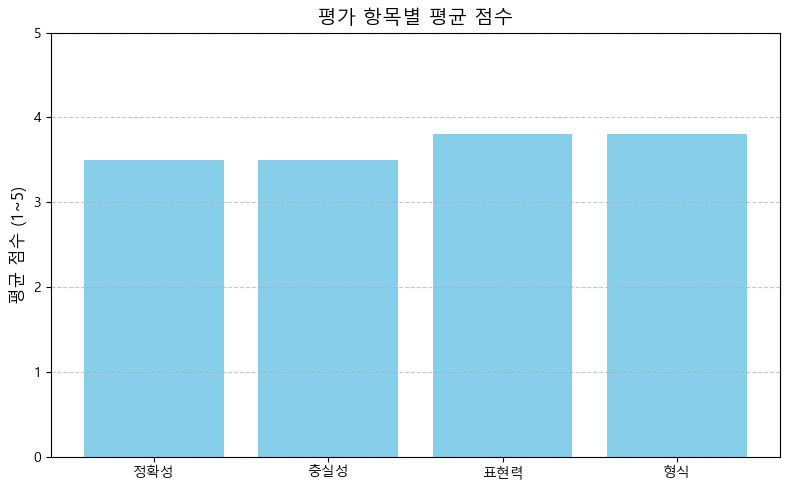

In [17]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.font_manager as fm

# ✅ 한글 폰트 설정 (운영체제에 따라 아래 중 하나 선택)
plt.rcParams['font.family'] = 'Malgun Gothic'       # 윈도우 사용자
# plt.rcParams['font.family'] = 'AppleGothic'       # macOS 사용자
# plt.rcParams['font.family'] = 'NanumGothic'       # Ubuntu (설치 필요)

# 📂 평가 결과 JSON 파일 불러오기
with open("evaluation_results.json", encoding="utf-8") as f:
    data = json.load(f)

# 📊 점수 추출
rows = []
for s in data:
    try:
        lines = s["evaluation"].splitlines()
        row = {
            "query": s["query"],
            "정확성": int(lines[0].split(":")[1].strip()),
            "충실성": int(lines[1].split(":")[1].strip()),
            "표현력": int(lines[2].split(":")[1].strip()),
            "형식": int(lines[3].split(":")[1].strip())
        }
        rows.append(row)
    except:
        continue

df = pd.DataFrame(rows)

# 📈 평균 점수 계산
average_scores = df[["정확성", "충실성", "표현력", "형식"]].mean()

# 🎨 막대 그래프 시각화
plt.figure(figsize=(8, 5))
plt.bar(average_scores.index, average_scores.values, color='skyblue')
plt.ylim(0, 5)
plt.title("평가 항목별 평균 점수", fontsize=14)
plt.ylabel("평균 점수 (1~5)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


✅ 표현력/형식 항목은 매우 우수: 사용자 친화적인 설명과 출력 포맷은 대부분 잘 지켜졌습니다.

⚠️ 정확성/충실성은 상대적으로 낮음: 병해충 질문에서 기술적 오류나 정보 부족이 나타나 평균 점수를 끌어내렸습니다.